In [109]:
import pandas as pd
import os
from itables import show
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [18]:
#finding out how many cpu cores you have
!wmic cpu get NumberOfCores,NumberOfLogicalProcessors

#divide the work between the existing cores - 1
os.environ['OMP_NUM_THREADS']='7'

NumberOfCores  NumberOfLogicalProcessors  

4              8                          





# Prepare data set for prediction

In [2]:
traffic = pd.read_csv('traffic.csv')
weather = pd.read_csv('weather_data.csv')
emissions = pd.read_csv('emission_huegelstr.csv')

In [3]:
weather

,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],datetime
0,1004.0,61.0,11.5,2.6,235.0,2018-01-01 00:30:00
1,1004.0,62.7,11.0,2.7,244.0,2018-01-01 01:00:00
2,1004.0,64.0,10.7,2.0,229.0,2018-01-01 01:30:00
3,1004.0,65.5,10.4,2.1,235.0,2018-01-01 02:00:00
4,1005.0,65.0,10.2,2.6,243.0,2018-01-01 02:30:00
...,...,...,...,...,...,...
100143,1007.0,85.2,18.9,0.8,166.0,2023-09-18 08:00:00
100144,1007.0,81.6,19.4,0.9,157.0,2023-09-18 08:30:00
100145,1007.0,79.8,19.8,1.2,173.0,2023-09-18 09:00:00
100146,1007.0,76.4,20.4,1.2,176.0,2023-09-18 09:30:00


In [34]:
pred_data = traffic.merge(weather, how='left', left_on= 'roundedTimestamp', right_on='datetime').merge(emissions[['PM10','datetime']], how='left', left_on= 'roundedTimestamp', right_on='datetime' )
pred_data.drop(columns=['datetime_y', 'roundedTimestamp'], inplace = True)
show(pred_data)

df = pred_data.copy

KeyError: "None of [Index(['PM10', 'datetime'], dtype='object', name='datetime_x')] are in the [index]"

In [9]:
df.index = pd.to_datetime(df['datetime_x'], format='%Y-%m-%d %H:%M:%S')
df[:26]

,Bezeichnung,D1Z,D2Z,D3Z,D4Z,D5Z,D6Z,D7Z,D8Z,D9Z,...,D62Z,D63Z,D64Z,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],datetime_x,PM10
datetime_x,,,,,,,,,,,,,,,,,,,,,
2022-08-26 07:00:00,A1,8.0,13.0,89.0,105.0,38.0,11.0,22.0,22.0,62.0,...,0.0,0.0,0.0,1012.0,78.8,20.2,0.5,70.0,2022-08-26 07:00:00,23.2
2022-08-26 07:30:00,A1,27.0,28.0,196.0,223.0,81.0,26.0,53.0,73.0,114.0,...,0.0,0.0,0.0,1012.0,77.9,20.4,0.4,55.0,2022-08-26 07:30:00,28.0
2022-08-26 08:00:00,A1,9.0,17.0,124.0,131.0,53.0,14.0,38.0,55.0,88.0,...,0.0,0.0,0.0,1012.0,75.1,21.2,0.6,35.0,2022-08-26 08:00:00,32.6
2022-08-29 07:00:00,A1,14.0,13.0,115.0,119.0,48.0,7.0,28.0,37.0,56.0,...,0.0,0.0,0.0,1019.0,79.4,13.0,1.2,40.0,2022-08-29 07:00:00,10.6
2022-08-29 07:30:00,A1,31.0,28.0,250.0,257.0,81.0,24.0,48.0,55.0,151.0,...,0.0,0.0,0.0,1019.0,76.7,13.9,1.2,43.0,2022-08-29 07:30:00,11.3
2022-08-29 08:00:00,A1,17.0,12.0,149.0,165.0,59.0,13.0,32.0,45.0,95.0,...,0.0,0.0,0.0,1019.0,73.4,15.0,1.1,54.0,2022-08-29 08:00:00,11.6
2022-09-01 07:00:00,A1,10.0,12.0,102.0,123.0,27.0,13.0,30.0,37.0,72.0,...,0.0,0.0,0.0,1018.0,83.5,13.6,0.5,46.0,2022-09-01 07:00:00,11.3
2022-09-01 07:30:00,A1,37.0,41.0,251.0,287.0,95.0,27.0,78.0,104.0,165.0,...,0.0,0.0,0.0,1018.0,81.3,14.5,0.6,56.0,2022-09-01 07:30:00,14.6
2022-09-01 08:00:00,A1,20.0,27.0,135.0,161.0,72.0,15.0,41.0,62.0,111.0,...,0.0,0.0,0.0,1018.0,76.9,15.7,1.0,40.0,2022-09-01 08:00:00,19.6


# Univariate Time Series Forecasting (LSTM)

<Axes: xlabel='datetime_x'>

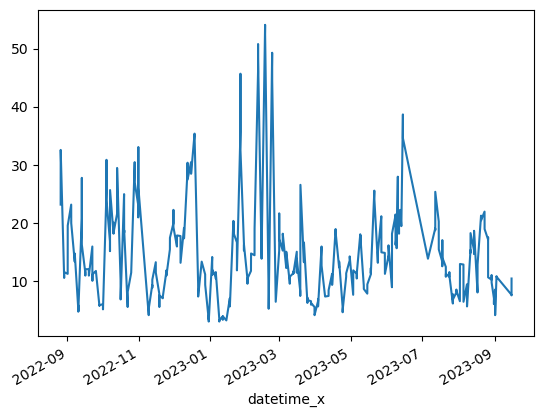

In [12]:
emissions = df['PM10']
emissions.plot()

In [13]:
# [[[1], [2], [3], [4], [5]]] [6]
# [[[2], [3], [4], [5], [6]]] [7]
# [[[3], [4], [5], [6], [7]]] [8]

def df_to_X_y(df, window_size=5):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [14]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(emissions, WINDOW_SIZE)
X1.shape, y1.shape

((5827, 5, 1), (5827,))

In [15]:
X_train1, y_train1 = X1[:4000], y1[:4000]
X_val1, y_val1 = X1[4000:4800], y1[4000:4800]
X_test1, y_test1 = X1[4800:], y1[4800:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((4000, 5, 1), (4000,), (800, 5, 1), (800,), (1027, 5, 1), (1027,))

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [19]:
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [20]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp1])

Epoch 1/10
121/125 [============================>.] - ETA: 0s - loss: 256.1839 - root_mean_squared_error: 16.0057

125/125 [==============================] - 22s 141ms/step - loss: 254.6886 - root_mean_squared_error: 15.9590 - val_loss: 238.3633 - val_root_mean_squared_error: 15.4390
Epoch 2/10
116/125 [==========================>...] - ETA: 0s - loss: 196.2001 - root_mean_squared_error: 14.0071

125/125 [==============================] - 13s 105ms/step - loss: 193.2422 - root_mean_squared_error: 13.9012 - val_loss: 172.1383 - val_root_mean_squared_error: 13.1201
Epoch 3/10
116/125 [==========================>...] - ETA: 0s - loss: 135.1630 - root_mean_squared_error: 11.6260

125/125 [==============================] - 15s 124ms/step - loss: 134.1337 - root_mean_squared_error: 11.5816 - val_loss: 122.2984 - val_root_mean_squared_error: 11.0589
Epoch 4/10
124/125 [============================>.] - ETA: 0s - loss: 100.8133 - root_mean_squared_error: 10.0406

125/125 [==============================] - 18s 143ms/step - loss: 100.7765 - root_mean_squared_error: 10.0388 - val_loss: 99.8970 - val_root_mean_squared_error: 9.9948
Epoch 5/10
124/125 [============================>.] - ETA: 0s - loss: 86.5703 - root_mean_squared_error: 9.3043

125/125 [==============================] - 16s 126ms/step - loss: 86.8760 - root_mean_squared_error: 9.3207 - val_loss: 89.6850 - val_root_mean_squared_error: 9.4702
Epoch 6/10
124/125 [============================>.] - ETA: 0s - loss: 79.9897 - root_mean_squared_error: 8.9437

125/125 [==============================] - 20s 163ms/step - loss: 79.5814 - root_mean_squared_error: 8.9208 - val_loss: 82.6067 - val_root_mean_squared_error: 9.0888
Epoch 7/10
119/125 [===========================>..] - ETA: 0s - loss: 74.5821 - root_mean_squared_error: 8.6361

125/125 [==============================] - 17s 133ms/step - loss: 73.6681 - root_mean_squared_error: 8.5830 - val_loss: 75.9647 - val_root_mean_squared_error: 8.7158
Epoch 8/10
122/125 [============================>.] - ETA: 0s - loss: 68.3043 - root_mean_squared_error: 8.2646

125/125 [==============================] - 17s 138ms/step - loss: 67.8886 - root_mean_squared_error: 8.2395 - val_loss: 70.3923 - val_root_mean_squared_error: 8.3900
Epoch 9/10
122/125 [============================>.] - ETA: 0s - loss: 62.4827 - root_mean_squared_error: 7.9046

125/125 [==============================] - 17s 140ms/step - loss: 62.7549 - root_mean_squared_error: 7.9218 - val_loss: 64.8969 - val_root_mean_squared_error: 8.0559
Epoch 10/10
118/125 [===========================>..] - ETA: 0s - loss: 59.1280 - root_mean_squared_error: 7.6895

125/125 [==============================] - 22s 176ms/step - loss: 58.7959 - root_mean_squared_error: 7.6678 - val_loss: 61.1792 - val_root_mean_squared_error: 7.8217


In [21]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

In [22]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

125/125 [==============================] - 2s 6ms/step


,Train Predictions,Actuals
0,13.622010,11.6
1,12.852242,11.3
2,12.448582,14.6
3,14.167357,19.6
4,16.603041,23.2
...,...,...
3995,16.614370,17.7
3996,16.728550,17.9
3997,16.839226,17.8
3998,16.841763,13.4


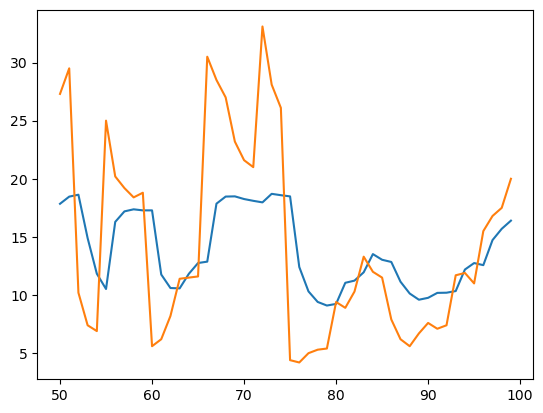

In [23]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

In [24]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

25/25 [==============================] - 0s 8ms/step


,Val Predictions,Actuals
0,14.263607,19.2
1,16.511623,17.4
2,16.495144,17.5
3,16.678539,29.1
4,18.428648,30.4
...,...,...
795,16.460543,16.3
796,16.187681,10.4
797,13.122576,9.6
798,12.028946,10.5


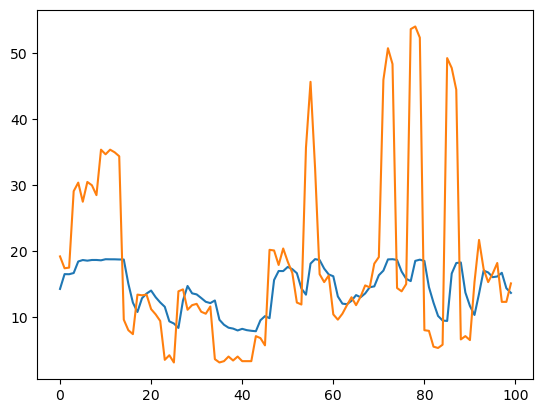

In [25]:
plt.plot(val_results['Val Predictions'][:100])
plt.plot(val_results['Actuals'][:100])

In [26]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

33/33 [==============================] - 1s 4ms/step


,Test Predictions,Actuals
0,12.458536,13.0
1,13.327362,11.8
2,12.998719,13.1
3,13.579942,14.8
4,14.517666,14.5
...,...,...
1022,11.349430,10.9
1023,11.990904,10.8
1024,12.349892,7.7
1025,11.161692,7.6


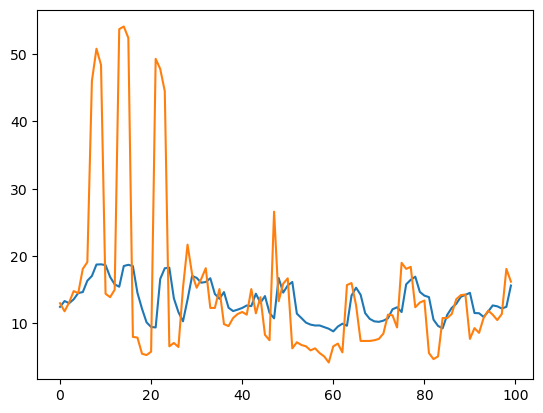

In [27]:
plt.plot(test_results['Test Predictions'][:100])
plt.plot(test_results['Actuals'][:100])

## Convolutional Neural Network

In [28]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 4, 64)             192       
                                                                 
 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 8)                 2056      
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [29]:
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [30]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp2])

Epoch 1/10
117/125 [===========================>..] - ETA: 0s - loss: 189.3554 - root_mean_squared_error: 13.7606

125/125 [==============================] - 5s 34ms/step - loss: 183.3951 - root_mean_squared_error: 13.5423 - val_loss: 91.6827 - val_root_mean_squared_error: 9.5751
Epoch 2/10
121/125 [============================>.] - ETA: 0s - loss: 75.1201 - root_mean_squared_error: 8.6672

125/125 [==============================] - 2s 17ms/step - loss: 74.9463 - root_mean_squared_error: 8.6572 - val_loss: 68.0379 - val_root_mean_squared_error: 8.2485
Epoch 3/10
118/125 [===========================>..] - ETA: 0s - loss: 59.0765 - root_mean_squared_error: 7.6861

125/125 [==============================] - 3s 24ms/step - loss: 59.4301 - root_mean_squared_error: 7.7091 - val_loss: 56.2023 - val_root_mean_squared_error: 7.4968
Epoch 4/10
125/125 [==============================] - ETA: 0s - loss: 50.3884 - root_mean_squared_error: 7.0985

125/125 [==============================] - 3s 21ms/step - loss: 50.3884 - root_mean_squared_error: 7.0985 - val_loss: 49.1613 - val_root_mean_squared_error: 7.0115
Epoch 5/10
125/125 [==============================] - ETA: 0s - loss: 44.9420 - root_mean_squared_error: 6.7039

125/125 [==============================] - 3s 26ms/step - loss: 44.9420 - root_mean_squared_error: 6.7039 - val_loss: 45.0698 - val_root_mean_squared_error: 6.7134
Epoch 6/10
107/125 [========================>.....] - ETA: 0s - loss: 41.5436 - root_mean_squared_error: 6.4454

125/125 [==============================] - 3s 24ms/step - loss: 41.7826 - root_mean_squared_error: 6.4639 - val_loss: 43.0783 - val_root_mean_squared_error: 6.5634
Epoch 7/10
124/125 [============================>.] - ETA: 0s - loss: 40.0119 - root_mean_squared_error: 6.3255

125/125 [==============================] - 3s 24ms/step - loss: 40.0868 - root_mean_squared_error: 6.3314 - val_loss: 41.3868 - val_root_mean_squared_error: 6.4333
Epoch 8/10
111/125 [=========================>....] - ETA: 0s - loss: 37.5211 - root_mean_squared_error: 6.1254

125/125 [==============================] - 3s 20ms/step - loss: 39.0336 - root_mean_squared_error: 6.2477 - val_loss: 40.5175 - val_root_mean_squared_error: 6.3653
Epoch 9/10
114/125 [==========================>...] - ETA: 0s - loss: 39.0350 - root_mean_squared_error: 6.2478

125/125 [==============================] - 3s 26ms/step - loss: 38.3272 - root_mean_squared_error: 6.1909 - val_loss: 39.9356 - val_root_mean_squared_error: 6.3195
Epoch 10/10
122/125 [============================>.] - ETA: 0s - loss: 38.2703 - root_mean_squared_error: 6.1863

125/125 [==============================] - 3s 21ms/step - loss: 37.9420 - root_mean_squared_error: 6.1597 - val_loss: 39.5050 - val_root_mean_squared_error: 6.2853


## GRU (Gated Recurrent Unit)

In [31]:
model3 = Sequential()
model3.add(InputLayer((5, 1)))
model3.add(GRU(64))
model3.add(Dense(8, 'relu'))
model3.add(Dense(1, 'linear'))
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 64)                12864     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
 dense_5 (Dense)             (None, 1)                 9         
                                                                 
Total params: 13,393
Trainable params: 13,393
Non-trainable params: 0
_________________________________________________________________


In [32]:
cp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [33]:
model3.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=10, callbacks=[cp3])

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 281.2291 - root_mean_squared_error: 16.7699

125/125 [==============================] - 18s 118ms/step - loss: 281.2291 - root_mean_squared_error: 16.7699 - val_loss: 264.4203 - val_root_mean_squared_error: 16.2610
Epoch 2/10
122/125 [============================>.] - ETA: 0s - loss: 227.0378 - root_mean_squared_error: 15.0678

125/125 [==============================] - 12s 100ms/step - loss: 226.7217 - root_mean_squared_error: 15.0573 - val_loss: 214.4881 - val_root_mean_squared_error: 14.6454
Epoch 3/10
113/125 [==========================>...] - ETA: 0s - loss: 163.7390 - root_mean_squared_error: 12.7961

125/125 [==============================] - 11s 91ms/step - loss: 160.4006 - root_mean_squared_error: 12.6649 - val_loss: 140.1203 - val_root_mean_squared_error: 11.8372
Epoch 4/10
119/125 [===========================>..] - ETA: 0s - loss: 113.9864 - root_mean_squared_error: 10.6764

125/125 [==============================] - 11s 91ms/step - loss: 112.5770 - root_mean_squared_error: 10.6102 - val_loss: 108.2469 - val_root_mean_squared_error: 10.4042
Epoch 5/10
123/125 [============================>.] - ETA: 0s - loss: 90.7656 - root_mean_squared_error: 9.5271

125/125 [==============================] - 11s 92ms/step - loss: 90.7137 - root_mean_squared_error: 9.5244 - val_loss: 90.7175 - val_root_mean_squared_error: 9.5246
Epoch 6/10
117/125 [===========================>..] - ETA: 0s - loss: 78.6619 - root_mean_squared_error: 8.8692

125/125 [==============================] - 12s 95ms/step - loss: 77.6429 - root_mean_squared_error: 8.8115 - val_loss: 78.6238 - val_root_mean_squared_error: 8.8670
Epoch 7/10
123/125 [============================>.] - ETA: 0s - loss: 68.1311 - root_mean_squared_error: 8.2542

125/125 [==============================] - 13s 102ms/step - loss: 68.6744 - root_mean_squared_error: 8.2870 - val_loss: 70.5856 - val_root_mean_squared_error: 8.4015
Epoch 8/10
125/125 [==============================] - ETA: 0s - loss: 62.6466 - root_mean_squared_error: 7.9150

125/125 [==============================] - 13s 102ms/step - loss: 62.6466 - root_mean_squared_error: 7.9150 - val_loss: 65.0731 - val_root_mean_squared_error: 8.0668
Epoch 9/10
122/125 [============================>.] - ETA: 0s - loss: 58.8106 - root_mean_squared_error: 7.6688

125/125 [==============================] - 12s 96ms/step - loss: 58.4406 - root_mean_squared_error: 7.6446 - val_loss: 60.7980 - val_root_mean_squared_error: 7.7973
Epoch 10/10
111/125 [=========================>....] - ETA: 0s - loss: 54.2419 - root_mean_squared_error: 7.3649

125/125 [==============================] - 12s 95ms/step - loss: 54.9930 - root_mean_squared_error: 7.4157 - val_loss: 57.2446 - val_root_mean_squared_error: 7.5660


# Multivariate Time Series Forecasting (LSTM)

## Preprocessing

In [166]:
multi_df = pred_data.copy()
multi_df['Seconds'] = multi_df.index.map(pd.Timestamp.timestamp)
multi_df

,Bezeichnung,D1Z,D2Z,D3Z,D4Z,D5Z,D6Z,D7Z,D8Z,D9Z,...,D63Z,D64Z,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],datetime_x,PM10,Seconds
datetime_x,,,,,,,,,,,,,,,,,,,,,
2022-08-26 07:00:00,A1,8.0,13.0,89.0,105.0,38.0,11.0,22.0,22.0,62.0,...,0.0,0.0,1012.0,78.8,20.2,0.5,70.0,2022-08-26 07:00:00,23.2,1.661497e+09
2022-08-26 07:30:00,A1,27.0,28.0,196.0,223.0,81.0,26.0,53.0,73.0,114.0,...,0.0,0.0,1012.0,77.9,20.4,0.4,55.0,2022-08-26 07:30:00,28.0,1.661499e+09
2022-08-26 08:00:00,A1,9.0,17.0,124.0,131.0,53.0,14.0,38.0,55.0,88.0,...,0.0,0.0,1012.0,75.1,21.2,0.6,35.0,2022-08-26 08:00:00,32.6,1.661501e+09
2022-08-29 07:00:00,A1,14.0,13.0,115.0,119.0,48.0,7.0,28.0,37.0,56.0,...,0.0,0.0,1019.0,79.4,13.0,1.2,40.0,2022-08-29 07:00:00,10.6,1.661756e+09
2022-08-29 07:30:00,A1,31.0,28.0,250.0,257.0,81.0,24.0,48.0,55.0,151.0,...,0.0,0.0,1019.0,76.7,13.9,1.2,43.0,2022-08-29 07:30:00,11.3,1.661758e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-02 04:00:00,A90,6.0,4.0,2.0,8.0,30.0,4.0,2.0,0.0,4.0,...,0.0,0.0,1016.0,96.6,12.7,NaN,NaN,2023-09-02 04:00:00,10.9,1.693627e+09
2023-09-02 04:30:00,A90,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1017.0,96.6,12.6,NaN,NaN,2023-09-02 04:30:00,10.8,1.693629e+09
2023-09-14 23:00:00,A90,1.0,6.0,1.0,11.0,22.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1019.0,94.6,11.0,NaN,NaN,2023-09-14 23:00:00,7.7,1.694732e+09


In [167]:
day = 60*60*24
year = 365.2425*day

multi_df['Day sin'] = np.sin(multi_df['Seconds'] * (2* np.pi / day))
multi_df['Day cos'] = np.cos(multi_df['Seconds'] * (2 * np.pi / day))
multi_df['Year sin'] = np.sin(multi_df['Seconds'] * (2 * np.pi / year))
multi_df['Year cos'] = np.cos(multi_df['Seconds'] * (2 * np.pi / year))
multi_df.head()


,Bezeichnung,D1Z,D2Z,D3Z,D4Z,D5Z,D6Z,D7Z,D8Z,D9Z,...,Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],datetime_x,PM10,Seconds,Day sin,Day cos,Year sin,Year cos
datetime_x,,,,,,,,,,,,,,,,,,,,,
2022-08-26 07:00:00,A1,8.0,13.0,89.0,105.0,38.0,11.0,22.0,22.0,62.0,...,20.2,0.5,70.0,2022-08-26 07:00:00,23.2,1.661497e+09,0.965926,-0.258819,-0.811779,-0.583965
2022-08-26 07:30:00,A1,27.0,28.0,196.0,223.0,81.0,26.0,53.0,73.0,114.0,...,20.4,0.4,55.0,2022-08-26 07:30:00,28.0,1.661499e+09,0.923880,-0.382683,-0.811988,-0.583674
2022-08-26 08:00:00,A1,9.0,17.0,124.0,131.0,53.0,14.0,38.0,55.0,88.0,...,21.2,0.6,35.0,2022-08-26 08:00:00,32.6,1.661501e+09,0.866025,-0.500000,-0.812197,-0.583383
2022-08-29 07:00:00,A1,14.0,13.0,115.0,119.0,48.0,7.0,28.0,37.0,56.0,...,13.0,1.2,40.0,2022-08-29 07:00:00,10.6,1.661756e+09,0.965926,-0.258819,-0.840822,-0.541311
2022-08-29 07:30:00,A1,31.0,28.0,250.0,257.0,81.0,24.0,48.0,55.0,151.0,...,13.9,1.2,43.0,2022-08-29 07:30:00,11.3,1.661758e+09,0.923880,-0.382683,-0.841016,-0.541010


In [168]:
#move target to be first column
column_to_move = multi_df.pop('PM10')
multi_df.insert(0, 'PM10', column_to_move)
multi_df

,PM10,Bezeichnung,D1Z,D2Z,D3Z,D4Z,D5Z,D6Z,D7Z,D8Z,...,Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],datetime_x,Seconds,Day sin,Day cos,Year sin,Year cos
datetime_x,,,,,,,,,,,,,,,,,,,,,
2022-08-26 07:00:00,23.2,A1,8.0,13.0,89.0,105.0,38.0,11.0,22.0,22.0,...,78.8,20.2,0.5,70.0,2022-08-26 07:00:00,1.661497e+09,9.659258e-01,-0.258819,-0.811779,-0.583965
2022-08-26 07:30:00,28.0,A1,27.0,28.0,196.0,223.0,81.0,26.0,53.0,73.0,...,77.9,20.4,0.4,55.0,2022-08-26 07:30:00,1.661499e+09,9.238795e-01,-0.382683,-0.811988,-0.583674
2022-08-26 08:00:00,32.6,A1,9.0,17.0,124.0,131.0,53.0,14.0,38.0,55.0,...,75.1,21.2,0.6,35.0,2022-08-26 08:00:00,1.661501e+09,8.660254e-01,-0.500000,-0.812197,-0.583383
2022-08-29 07:00:00,10.6,A1,14.0,13.0,115.0,119.0,48.0,7.0,28.0,37.0,...,79.4,13.0,1.2,40.0,2022-08-29 07:00:00,1.661756e+09,9.659258e-01,-0.258819,-0.840822,-0.541311
2022-08-29 07:30:00,11.3,A1,31.0,28.0,250.0,257.0,81.0,24.0,48.0,55.0,...,76.7,13.9,1.2,43.0,2022-08-29 07:30:00,1.661758e+09,9.238795e-01,-0.382683,-0.841016,-0.541010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-02 04:00:00,10.9,A90,6.0,4.0,2.0,8.0,30.0,4.0,2.0,0.0,...,96.6,12.7,NaN,NaN,2023-09-02 04:00:00,1.693627e+09,8.660254e-01,0.500000,-0.872985,-0.487747
2023-09-02 04:30:00,10.8,A90,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,...,96.6,12.6,NaN,NaN,2023-09-02 04:30:00,1.693629e+09,9.238795e-01,0.382683,-0.873160,-0.487434
2023-09-14 23:00:00,7.7,A90,1.0,6.0,1.0,11.0,22.0,0.0,0.0,0.0,...,94.6,11.0,NaN,NaN,2023-09-14 23:00:00,1.694732e+09,-2.588190e-01,0.965926,-0.958400,-0.285430


In [169]:
#drop unwanted columns
multi_df = multi_df.drop(columns = ['datetime_x', 'Seconds', 'Bezeichnung'])

In [170]:
multi_df

,PM10,D1Z,D2Z,D3Z,D4Z,D5Z,D6Z,D7Z,D8Z,D9Z,...,D64Z,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],Day sin,Day cos,Year sin,Year cos
datetime_x,,,,,,,,,,,,,,,,,,,,,
2022-08-26 07:00:00,23.2,8.0,13.0,89.0,105.0,38.0,11.0,22.0,22.0,62.0,...,0.0,1012.0,78.8,20.2,0.5,70.0,9.659258e-01,-0.258819,-0.811779,-0.583965
2022-08-26 07:30:00,28.0,27.0,28.0,196.0,223.0,81.0,26.0,53.0,73.0,114.0,...,0.0,1012.0,77.9,20.4,0.4,55.0,9.238795e-01,-0.382683,-0.811988,-0.583674
2022-08-26 08:00:00,32.6,9.0,17.0,124.0,131.0,53.0,14.0,38.0,55.0,88.0,...,0.0,1012.0,75.1,21.2,0.6,35.0,8.660254e-01,-0.500000,-0.812197,-0.583383
2022-08-29 07:00:00,10.6,14.0,13.0,115.0,119.0,48.0,7.0,28.0,37.0,56.0,...,0.0,1019.0,79.4,13.0,1.2,40.0,9.659258e-01,-0.258819,-0.840822,-0.541311
2022-08-29 07:30:00,11.3,31.0,28.0,250.0,257.0,81.0,24.0,48.0,55.0,151.0,...,0.0,1019.0,76.7,13.9,1.2,43.0,9.238795e-01,-0.382683,-0.841016,-0.541010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-02 04:00:00,10.9,6.0,4.0,2.0,8.0,30.0,4.0,2.0,0.0,4.0,...,0.0,1016.0,96.6,12.7,NaN,NaN,8.660254e-01,0.500000,-0.872985,-0.487747
2023-09-02 04:30:00,10.8,0.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,...,0.0,1017.0,96.6,12.6,NaN,NaN,9.238795e-01,0.382683,-0.873160,-0.487434
2023-09-14 23:00:00,7.7,1.0,6.0,1.0,11.0,22.0,0.0,0.0,0.0,0.0,...,0.0,1019.0,94.6,11.0,NaN,NaN,-2.588190e-01,0.965926,-0.958400,-0.285430


In [150]:
multi_df.describe()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73
count,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,5832.000000,...,5832.0,5832.000000,5832.000000,5832.000000,5338.000000,5338.000000,5832.000000,5832.000000,5832.000000,5832.000000
mean,-0.534407,-0.965262,-0.715432,-0.848757,-0.867685,-0.911670,-0.833430,-0.947723,-0.992732,-0.844883,...,-1.0,0.165275,0.293237,0.099266,-0.496665,-0.211478,-0.260665,0.010720,-0.029910,0.039854
std,0.355732,0.074740,0.232865,0.171407,0.162242,0.110471,0.170941,0.079344,0.036528,0.201330,...,0.0,0.312641,0.460020,0.398392,0.431533,0.513247,0.575349,0.778157,0.726466,0.686104
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.780392,-0.990119,-0.874510,-0.964856,-0.970000,-0.992268,-0.949275,-0.991540,-0.999548,-0.995370,...,-1.0,0.000000,-0.038348,-0.164384,-0.840000,-0.695906,-0.702030,-0.793353,-0.784366,-0.592416
50%,-0.615686,-0.978920,-0.764706,-0.900958,-0.916667,-0.943299,-0.876812,-0.969543,-0.996682,-0.912037,...,-1.0,0.153846,0.321534,0.116438,-0.600000,-0.198830,-0.371984,-0.130526,-0.072985,0.048117
75%,-0.400000,-0.957839,-0.607843,-0.792332,-0.826667,-0.871134,-0.775362,-0.928934,-0.992309,-0.773148,...,-1.0,0.346154,0.678466,0.383562,-0.280000,0.327485,0.017332,0.866025,0.685206,0.734063
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,-1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [156]:
#standardize

scaler = MinMaxScaler(feature_range=(-1, 1))

multi_df_scaled = scaler.fit_transform(multi_df)
multi_df = pd.DataFrame(multi_df_scaled, columns=multi_df.columns, index=multi_df.index)


In [157]:
multi_df

,PM10,D1Z,D2Z,D3Z,D4Z,D5Z,D6Z,D7Z,D8Z,D9Z,...,D64Z,Luftdruck[hPa],Relative Luftfeuchtigkeit[%],Temperatur[°C],Windgeschwindigkeit[m/s],Windrichtung[Grad],Day sin,Day cos,Year sin,Year cos
datetime_x,,,,,,,,,,,,,,,,,,,,,
2022-08-26 07:00:00,-0.211765,-0.994730,-0.898039,-0.715655,-0.650000,-0.902062,-0.920290,-0.962775,-0.996682,-0.712963,...,-1.0,0.038462,0.407080,0.719178,-0.92,-0.608187,1.000000,-0.258819,-0.811774,-0.585114
2022-08-26 07:30:00,-0.023529,-0.982213,-0.780392,-0.373802,-0.256667,-0.791237,-0.811594,-0.910321,-0.988991,-0.472222,...,-1.0,0.038462,0.380531,0.732877,-1.00,-0.695906,0.957225,-0.382683,-0.811983,-0.584823
2022-08-26 08:00:00,0.156863,-0.994071,-0.866667,-0.603834,-0.563333,-0.863402,-0.898551,-0.935702,-0.991706,-0.592593,...,-1.0,0.038462,0.297935,0.787671,-0.84,-0.812865,0.898368,-0.500000,-0.812192,-0.584531
2022-08-29 07:00:00,-0.705882,-0.990777,-0.898039,-0.632588,-0.603333,-0.876289,-0.949275,-0.952623,-0.994420,-0.740741,...,-1.0,0.307692,0.424779,0.226027,-0.36,-0.783626,1.000000,-0.258819,-0.840818,-0.542423
2022-08-29 07:30:00,-0.678431,-0.979578,-0.780392,-0.201278,-0.143333,-0.791237,-0.826087,-0.918782,-0.991706,-0.300926,...,-1.0,0.307692,0.345133,0.287671,-0.36,-0.766082,0.957225,-0.382683,-0.841012,-0.542122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-02 04:00:00,-0.694118,-0.996047,-0.968627,-0.993610,-0.973333,-0.922680,-0.971014,-0.996616,-1.000000,-0.981481,...,-1.0,0.192308,0.932153,0.205479,NaN,NaN,0.898368,0.500000,-0.872983,-0.488812
2023-09-02 04:30:00,-0.698039,-1.000000,-1.000000,-1.000000,-1.000000,-0.958763,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,0.230769,0.932153,0.198630,NaN,NaN,0.957225,0.382683,-0.873157,-0.488499
2023-09-14 23:00:00,-0.819608,-0.999341,-0.952941,-0.996805,-0.963333,-0.943299,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.0,0.307692,0.873156,0.089041,NaN,NaN,-0.245973,0.965926,-0.958400,-0.286320


In [195]:
def df_to_X_y2(df, window_size=250):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    #define y
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [196]:
X2, y2 = df_to_X_y2(multi_df)
X2.shape, y2.shape

((5582, 250, 74), (5582,))

In [197]:
#split data
X2_train, y2_train = X2[:4000], y2[:4000]
X2_val, y2_val = X2[4000:4800], y2[4000:4800]
X2_test, y2_test = X2[4800:], y2[4800:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape


((4000, 250, 74), (4000,), (800, 250, 74), (800,), (782, 250, 74), (782,))

In [198]:
#create model
from tensorflow.keras.backend import clear_session

clear_session()

model4 = Sequential()
model4.add(InputLayer((250, 74)))
model4.add(LSTM(64))
model4.add(Dense(8, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                35584     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 36,113
Trainable params: 36,113
Non-trainable params: 0
_________________________________________________________________


In [199]:
#set up checkpoint to save best model
cp4 = ModelCheckpoint('model4/', save_best_only=True)
#compile model 
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [200]:
#fit model
model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=10, callbacks=[cp4])

Epoch 1/10
125/125 [==============================] - ETA: 0s - loss: 304.1467 - root_mean_squared_error: 17.4398

125/125 [==============================] - 32s 232ms/step - loss: 304.1467 - root_mean_squared_error: 17.4398 - val_loss: 306.5759 - val_root_mean_squared_error: 17.5093
Epoch 2/10
125/125 [==============================] - ETA: 0s - loss: 303.7760 - root_mean_squared_error: 17.4292

125/125 [==============================] - 25s 200ms/step - loss: 303.7760 - root_mean_squared_error: 17.4292 - val_loss: 306.2055 - val_root_mean_squared_error: 17.4987
Epoch 3/10
125/125 [==============================] - ETA: 0s - loss: 303.4062 - root_mean_squared_error: 17.4186

125/125 [==============================] - 30s 239ms/step - loss: 303.4062 - root_mean_squared_error: 17.4186 - val_loss: 305.8337 - val_root_mean_squared_error: 17.4881
Epoch 4/10
125/125 [==============================] - ETA: 0s - loss: 303.0362 - root_mean_squared_error: 17.4079

125/125 [==============================] - 27s 216ms/step - loss: 303.0362 - root_mean_squared_error: 17.4079 - val_loss: 305.4630 - val_root_mean_squared_error: 17.4775
Epoch 5/10
125/125 [==============================] - ETA: 0s - loss: 302.6664 - root_mean_squared_error: 17.3973

125/125 [==============================] - 29s 230ms/step - loss: 302.6664 - root_mean_squared_error: 17.3973 - val_loss: 305.0921 - val_root_mean_squared_error: 17.4669
Epoch 6/10
125/125 [==============================] - ETA: 0s - loss: 302.2969 - root_mean_squared_error: 17.3867

125/125 [==============================] - 29s 236ms/step - loss: 302.2969 - root_mean_squared_error: 17.3867 - val_loss: 304.7216 - val_root_mean_squared_error: 17.4563
Epoch 7/10
125/125 [==============================] - ETA: 0s - loss: 301.9281 - root_mean_squared_error: 17.3761

125/125 [==============================] - 31s 250ms/step - loss: 301.9281 - root_mean_squared_error: 17.3761 - val_loss: 304.3518 - val_root_mean_squared_error: 17.4457
Epoch 8/10
125/125 [==============================] - ETA: 0s - loss: 301.5595 - root_mean_squared_error: 17.3655

125/125 [==============================] - 32s 256ms/step - loss: 301.5595 - root_mean_squared_error: 17.3655 - val_loss: 303.9826 - val_root_mean_squared_error: 17.4351
Epoch 9/10
125/125 [==============================] - ETA: 0s - loss: 301.1913 - root_mean_squared_error: 17.3549

125/125 [==============================] - 30s 239ms/step - loss: 301.1913 - root_mean_squared_error: 17.3549 - val_loss: 303.6133 - val_root_mean_squared_error: 17.4245
Epoch 10/10
125/125 [==============================] - ETA: 0s - loss: 300.8232 - root_mean_squared_error: 17.3443

125/125 [==============================] - 29s 231ms/step - loss: 300.8232 - root_mean_squared_error: 17.3443 - val_loss: 303.2448 - val_root_mean_squared_error: 17.4139


In [186]:
from sklearn.metrics import mean_squared_error as mse

def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

33/33 [==============================] - 1s 2ms/step


(      Predictions   Actuals
 0       -0.117869 -0.658824
 1       -0.117869 -0.607843
 2       -0.117869 -0.541176
 3       -0.117869 -0.552941
 4       -0.117869 -0.411765
 ...           ...       ...
 1021    -0.117869 -0.694118
 1022    -0.117869 -0.698039
 1023    -0.117869 -0.819608
 1024    -0.117869 -0.823529
 1025    -0.117869 -0.709804
 
 [1026 rows x 2 columns],
 0.3022967144238068)

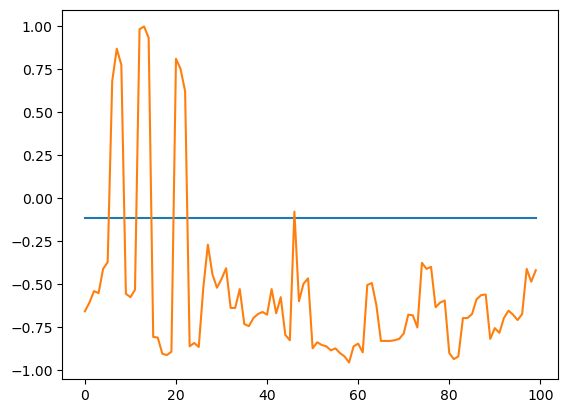

In [165]:
plot_predictions1(model4, X2_test, y2_test)

25/25 [==============================] - 2s 56ms/step


(     Predictions  Actuals
 0       0.124057     16.3
 1       0.124057     11.5
 2       0.124057     11.0
 3       0.124057     12.1
 4       0.124057     12.1
 ..           ...      ...
 777     0.124057     10.9
 778     0.124057     10.8
 779     0.124057      7.7
 780     0.124057      7.6
 781     0.124057     10.5
 
 [782 rows x 2 columns],
 299.7539326563505)

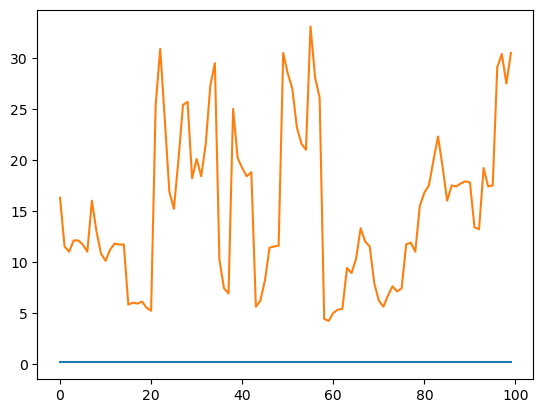

In [201]:
plot_predictions1(model4, X2_test, y2_test)

In [ ]:
cp5 = ModelCheckpoint('model5/', save_best_only=True)
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
model5.fit(X3_train, y3_train, validation_data=(X3_val, y3_val), epochs=10, callbacks=[cp5])